In [1]:
topics_covered_in_here = {
    1: "data (prepare and load)",
    2: "build model",
    3: "fitting model",
    4: "make predictions and evaluating",
    5: "saving and loading a model",
    6: "putting it all together"
}

topics_covered_in_here

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting model',
 4: 'make predictions and evaluating',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [2]:
import torch
from torch import nn # nn contains all the building blocks for Neural Networks
import matplotlib.pyplot as plt

torch.__version__

'2.6.0+cu124'

## 1. Data (preparing and loading)

Can be spreadsheets, images, videos, audio, DNA, text etc.

ML is a game of 2 parts:
1. Get data into numerical representation
2. Build model to learn patterns in that numerical representations

To showcase these, creating some known data using linear regression

In [3]:
# Parameters *known*
weight = 0.7
bias = 0.3

# creating data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets

In [5]:
# train-test- split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [5]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

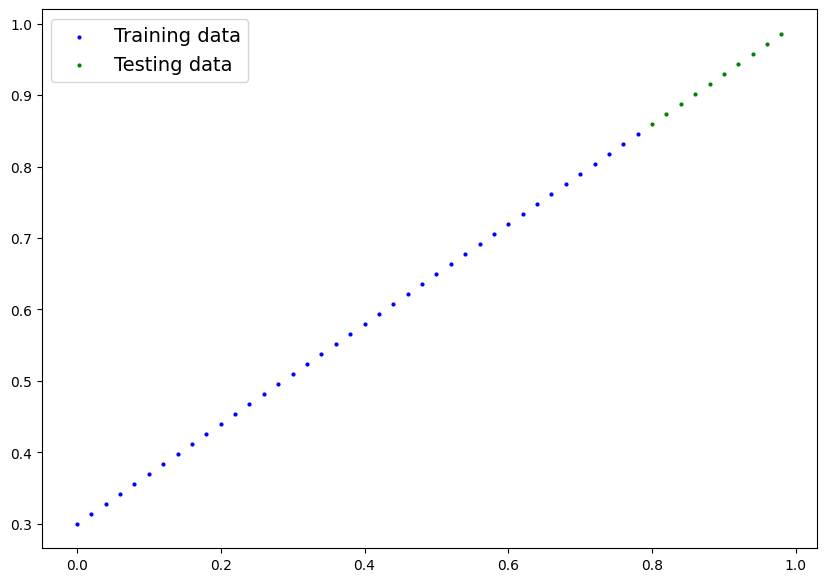

In [7]:
plot_predictions();

## 2. Build model

What our model does is it starts with random values (weight and bias) and then look at training data and adjust the weight and bias to better represent (or get closer to) the ideal values (the weight and bias values we used to create the data)

how does it do so:
two main algorithms:
1. Gradient descent
2. Backpropogation

In [8]:
# creating linear regression model class

class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherits from nn.Module
  def __init__(self) -> None:
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, # start with a random weight
                                            requires_grad=True, # can this parameter be updated via gradient descent?
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1, # start with a random bias
                                         requires_grad=True, # can this parameter be updated via gradient descent?
                                         dtype=torch.float))

    # Require forward method to be overridden
    # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # x is the input data
    return self.weights * x + self.bias # y = mx + c

### PyTorch model building essentials

* torch.nn - contains all the buildings for computational graph (a NN can be considered a computational graph)
* torch.nn.Parameter - what parametrs should our model try and learn, often PyTorch layer from torch.nn wil set these for us
* torch.nn.Module - The base class for all NN modules, if you inherit it, must override forward() method
* torch.optim - this is where optimizers in PyTorch are, they will help with gradient descent

In [9]:
# Creating a random seed
torch.manual_seed(42)

# create an instance of the model we created
model_0 = LinearRegressionModel()

# checking parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

To check our model's predictive power

When we pass data to the model, its going to run it through forward method

In [11]:
# make predictions with model - without trainig
with torch.inference_mode(): # inference_mode doesn't track gradient. Because when making predictions you dont need to track gradient to update it later.
  y_preds = model_0(X_test)


# We can also do something similar with with torch.no_grad(), but inference_mode() is preferred
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

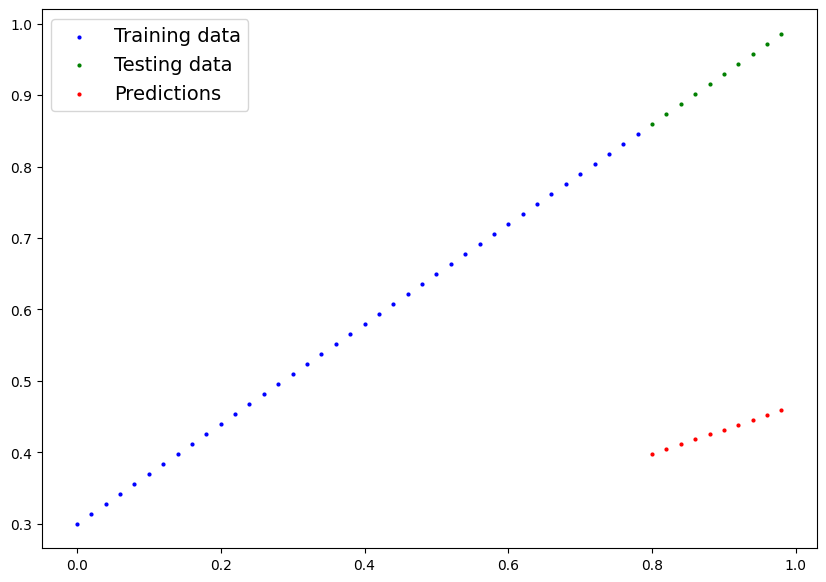

In [12]:
plot_predictions(predictions=y_preds)

## 3. Training the model

The whole idea is to to train a model from unknown paramters to to parameters which better represent the data.

Things needed to trian the data:
* Loss function
* Optimizer

Specifically for PyTorch, we need:
* A training loop
* A testing loop

In [13]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [14]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [15]:
# setup a loss func
loss_fn = nn.L1Loss()

# setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(), lr = 0.01) # lr = learning rate = hyperparameter (set by us)

#### Building a training loop and testing in loop in PyTorch

0. Loop through the data
1. forward pass (this invlovesdata moving through our model's `forward()` functions to make predictions - called forward propogation)
2. Calculate the loss (compare forward pass predictions to ground tructh labels)
3. Optimizier zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each paramter of ou model with respect to the loss
5. Optimizer step - use the optimizer to adjust adjust our model parameters to try and improve the loss

In [16]:
# An epoch is one loop through the data
epochs = 200

# Tracking different values
epoch_count = []
loss_values = []
test_loss_values = []

### Training
# loop through the data:
for epoch in range(epochs):
  # set the model to training mode
  model_0.train() # train mode in PyTorch sets all paramaters that require gradients to require gradients. require_grad=True

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)
  # print(f"Loss: {loss}")

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform Backpropogation on the loss with respect to the parameter of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default the how the optimizer changes will accumulate through the loop so we have to zero them above in step 3 for the next iteration of the loop

  ### Testing
  model_0.eval() # turns off different settings in model which are not needed for evaluation/testing (dropout/batchnorm layers)
  with torch.inference_mode(): # turns off gradient_descent and more things behind the scene
    # 1. Forward pass on test data
    test_pred = model_0(X_test)

    # 2. Calculate loss on test_pred vs y_test
    test_loss = loss_fn(test_pred, y_test)

  # Print out what happened
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch : {epoch}, Loss: {loss}, Test Loss: {test_loss}")
    print(model_0.state_dict())

Epoch : 0, Loss: 0.31288138031959534, Test Loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch : 10, Loss: 0.1976713240146637, Test Loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch : 20, Loss: 0.08908725529909134, Test Loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch : 30, Loss: 0.053148526698350906, Test Loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch : 40, Loss: 0.04543796554207802, Test Loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch : 50, Loss: 0.04167863354086876, Test Loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch : 60, Loss: 0.03818932920694351, Test Loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788]))])
E

In [17]:
import numpy as np
np.array(torch.tensor(loss_values).cpu().numpy())

array([0.31288138, 0.19767132, 0.08908726, 0.05314853, 0.04543797,
       0.04167863, 0.03818933, 0.0347609 , 0.03132383, 0.0278874 ,
       0.02445896, 0.02102021, 0.01758547, 0.01415539, 0.01071659,
       0.00728353, 0.00385178, 0.00893248, 0.00893248, 0.00893248],
      dtype=float32)

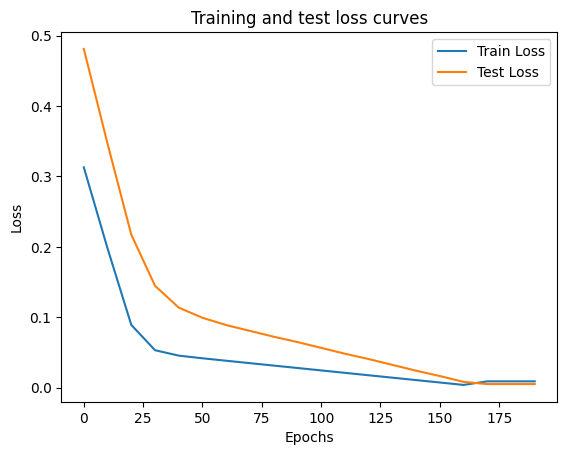

In [18]:
# plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label = "Train Loss")
plt.plot(epoch_count, test_loss_values, label = "Test Loss")
plt.title("Training and test loss curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

In [19]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

In [20]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [21]:
weight, bias

(0.7, 0.3)

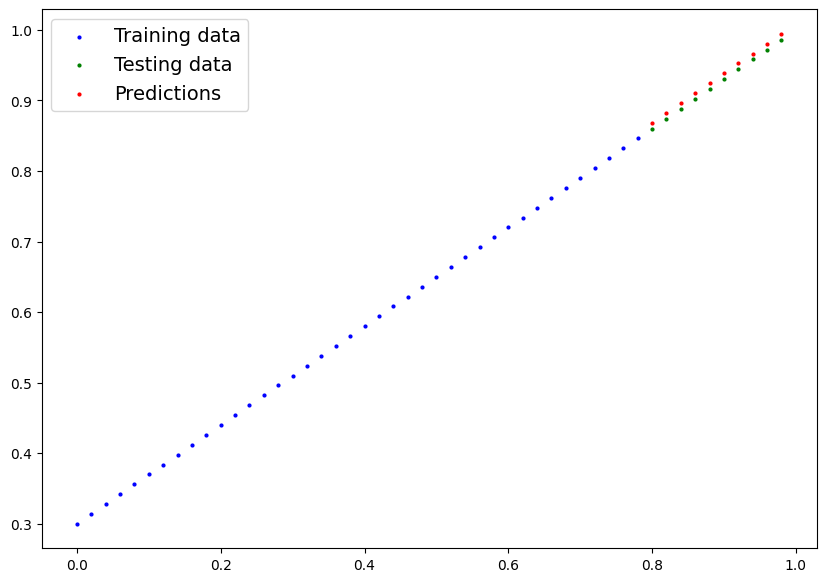

In [22]:
plot_predictions(predictions=y_preds_new)

## 4. Saving a model in PyTorch

3 main methods to save and load models

1. `torch.save()` - allows you to save PyTorch object in python pickle format
2. `torch.load()` - allows you to load a saved PyTorch object
3. `torch.nn.Module.laod_state_dict()` - this allows to load model's saved state dictionary

In [23]:
# Saving a PyTorch model
from pathlib import Path

# 1. Create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [24]:
! ls -l models

total 4
-rw-r--r-- 1 root root 1680 Jun 19 17:09 01_pytorch_workflow_model_0.pth


## 5. Loading a PyTorch model

Since we just saved the state_dict. We will have to create a new instance of our model class and load the saved state_dict into it.

In [25]:
# To load in a saved state_dict we have instantiate a new instance of the model class
loaded_model_0 = LinearRegressionModel()
print(loaded_model_0.state_dict())

# Load the saved state_dict of model_0 which we saved
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
print(loaded_model_0.state_dict()) # Loaded

OrderedDict([('weights', tensor([0.2345])), ('bias', tensor([0.2303]))])
OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])


In [26]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

# Compare it with the predictions earlier
y_preds_new == loaded_model_preds # Same predictions. Hence our model is same!!!!

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together
putting it all together in one place

In [3]:
# Import pytorch
import torch
from torch import nn
import matplotlib.pyplot as plt

# check pytorch version
torch.__version__

'2.6.0+cu124'

Create device agnostic Code

Basically if we've got GPU we will use GPU (if its available)

if not, use cpu

In [4]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using: {device}")

Using: cuda


### 6.1 Data

In [5]:
# Create data using linear regression y = mx + c
weight = 0.7
bias = 0.3

# create range values
start = 0
end = 1
step = 0.02

# create x & y
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [6]:
# plit data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [7]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

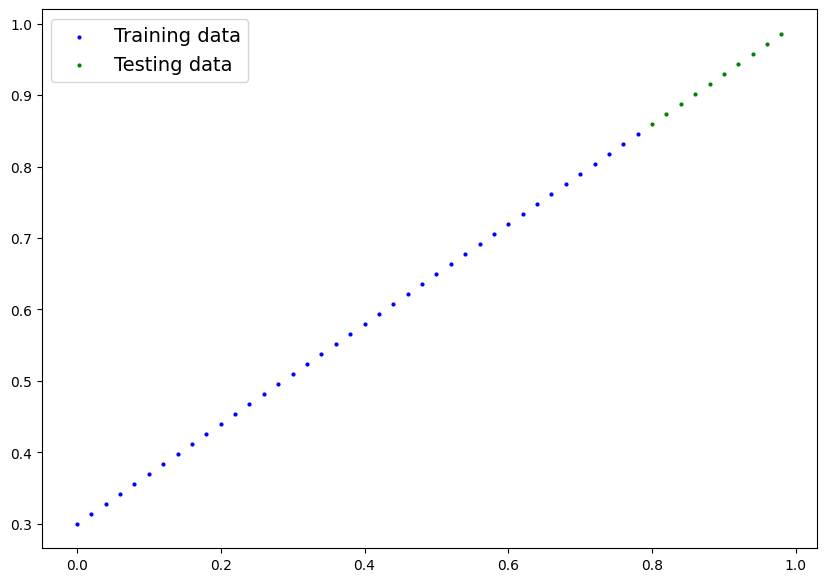

In [8]:
plot_predictions()

### 6.2 Building a model

In [9]:
class LinearRegressionModelV2(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    # Use nn.Linear() for creating model parameters
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# setting manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [10]:
# Check the model current device
next(model_1.parameters()).device # it is cpu but we running everything on GPU so we have to change the location

device(type='cpu')

In [11]:
# set the model to use target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.3 Training

for training we need:
* Loss function
* Optimizer
* Training loop
* Testing loop

In [12]:
# setup loss function
loss_fn = nn.L1Loss() # Same as MAE

# Setup optimizer
optimizer = torch.optim.SGD(lr = 0.01, params=model_1.parameters())

# Training loop
torch.manual_seed(42)

# Put all data on target device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = X_test.to(device)

# For training loop
epochs = 200

for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Zero grad
  optimizer.zero_grad()

  # 4. Perform Backpropogation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  # Testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)
    test_loss = loss_fn(test_pred, X_test)

  # Print out whats happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")

Epoch: 0 | Loss: 0.5551779866218567 | Test Loss: 0.6069762706756592
Epoch: 10 | Loss: 0.439968079328537 | Test Loss: 0.47226640582084656
Epoch: 20 | Loss: 0.3247582018375397 | Test Loss: 0.3375565707683563
Epoch: 30 | Loss: 0.20954833924770355 | Test Loss: 0.2028467208147049
Epoch: 40 | Loss: 0.09433845430612564 | Test Loss: 0.06813690066337585
Epoch: 50 | Loss: 0.023886388167738914 | Test Loss: 0.023275597020983696
Epoch: 60 | Loss: 0.019956795498728752 | Test Loss: 0.021817976608872414
Epoch: 70 | Loss: 0.016517987474799156 | Test Loss: 0.019164402037858963
Epoch: 80 | Loss: 0.013089174404740334 | Test Loss: 0.01817154325544834
Epoch: 90 | Loss: 0.009653178043663502 | Test Loss: 0.019074415788054466
Epoch: 100 | Loss: 0.006215683650225401 | Test Loss: 0.021886223927140236
Epoch: 110 | Loss: 0.00278724217787385 | Test Loss: 0.02736755646765232
Epoch: 120 | Loss: 0.0012645035749301314 | Test Loss: 0.02134581282734871
Epoch: 130 | Loss: 0.0012645035749301314 | Test Loss: 0.0213458128273

In [13]:
model_1.state_dict(), weight, bias

(OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
              ('linear_layer.bias', tensor([0.3025], device='cuda:0'))]),
 0.7,
 0.3)

### 6.4 Making and evaluating model

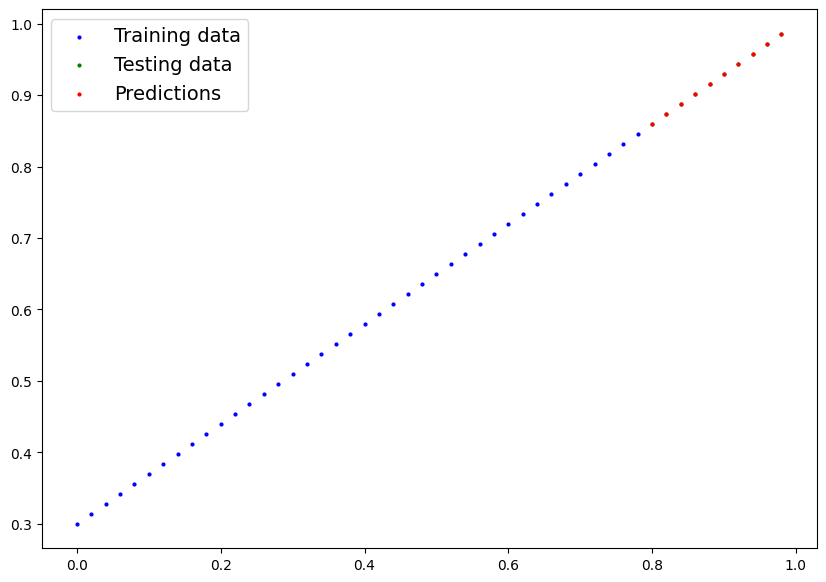

In [14]:
# Turn model into evaluation mode
model_1.eval()

with torch.inference_mode():
  y_preds = model_1(X_test)

plot_predictions(predictions=y_preds.cpu())

### 6.5 Saving and loading trained model

In [17]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [20]:
# Load a PyTorch Model

# Create a new instance of linear regression v2 class
loaded_model_1 = LinearRegressionModelV2()

# Load the saved model_1 state_dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put the model to device
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [21]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [22]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [23]:
# Evaluate model
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)

y_preds == loaded_model_1_preds # All predictions are same. SO model loaded successfully

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

## Mount google drive

### Subtask:
Connect your Google Drive to the Colab environment.


**Reasoning**:
The subtask is to connect Google Drive to the Colab environment. This requires importing the `drive` module from `google.colab` and calling the `mount()` function.



In [15]:
from google.colab import drive

## Copy the model file

### Subtask:
Copy the saved model file from the Colab file system to your Google Drive.


**Reasoning**:
Copy the saved model file from the Colab file system to Google Drive.



In [18]:
import shutil

# Define source and destination paths
source_path = MODEL_SAVE_PATH
destination_path = '/content/drive/MyDrive/my_models/01_pytorch_workflow_model_1.pth'

# Ensure the destination directory exists
destination_dir = Path(destination_path).parent
destination_dir.mkdir(parents=True, exist_ok=True)

# Copy the file
shutil.copy(source_path, destination_path)

print(f"Model saved to Google Drive at: {destination_path}")

Model saved to Google Drive at: /content/drive/MyDrive/my_models/01_pytorch_workflow_model_1.pth


## Verify the file in google drive

### Subtask:
Check your Google Drive to confirm the file has been successfully copied.


**Reasoning**:
Use a shell command to list the contents of the destination directory in Google Drive to confirm the file was copied successfully.



In [19]:
!ls -l /content/drive/MyDrive/my_models/

total 4
-rw------- 1 root root 1680 Jun 19 17:04 01_pytorch_workflow_model_0.pth
-rw------- 1 root root 1744 Jun 20 00:30 01_pytorch_workflow_model_1.pth


## Summary:

### Data Analysis Key Findings

*   The Google Drive was successfully mounted at `/content/drive`.
*   The model file was successfully copied from the Colab file system to the specified location in Google Drive: `/content/drive/MyDrive/my_models/01_pytorch_workflow_model_0.pth`.
*   The presence of the model file in the Google Drive directory was confirmed by listing the directory contents.

### Insights or Next Steps

*   The process successfully demonstrates how to save a model from a Colab environment to Google Drive for persistent storage and accessibility.
